In [21]:
import numpy as np
import pandas as pd
from scipy import stats
import random
import math
import matplotlib.pyplot as plt

## random generate numbers
n = 1000
mu = 0
sig = 1
x = np.random.normal(mu,sig, (n,3))
y = np.random.normal(mu,sig, (n,1))

b = np.array([1,1,5]).reshape(-1,1)
y += x@b
## real beta is [1,1.5]

In [22]:
class data_generate_process:
    def __init__(self, x, y):
        self.x = x
        self.y = y    
        
    def split(self, rate = 0.7, random = 1024, scale = False):
        ## Feature scaling is used to normalize the range of independent variables or features of data
        if scale:
            x = (x - np.mean(x))/x.std()
        
        n = len(y)
        random.seed(random)
        
        ##randomly spilte data into 70% train and 30% test
        index = list[range(n)]
        random.suffle(index)
        train = index[:int(rate*n)]
        test = index[int(rate*n):]
        
        self.train_x = x[train]
        self.test_x = x[test]
        self.train_y = y[train]
        self.test_y = y[test]
        
        return self.train_x, self.test_x, self.train_y, self.test_y

class model:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def bias(self, intercept):
        ## if need intercept, assign x0 as 1
        if intercept:
            n = len(self.x)
            ones = np.ones((n,1))
            return np.hstack([ones,self.x])
        return self.x
    
    def tidy(self, x, tails = 2):
        
        n, k = x.shape
        self.error = self.y - x@self.beta 

        self.vb = self.error.var()*np.linalg.inv(x.T@x)
        self.se = np.sqrt(np.diagonal(self.vb)).reshape(-1,1)
        self.t = np.divide(self.beta,self.se)
        self.pval = tails * (1 - stats.norm.cdf(self.t))
        
        names = ['Coef','Std err','t','p-value']
        values = [self.beta, self.se, self.t, self.pval]
        values = np.hstack(values)
        
        self.summary = pd.DataFrame(values, columns =names)

        self.rsq = 1 - self.error.var()/self.y.var()
        self.adjrsq = self.rsq*(n -1)/(n-k-1)
        
        var = self.error.var()
        ## sum function here is useless, but just in order to get a list, rather than a list in a list
        ## in this case, it's easily to plot graph
        self.sse = sum(self.error.T@self.error)
        
        logl = -n/2*np.log(2*var*math.pi) - 1/2/var*self.sse
        self.logl = logl.tolist()
        
        self.aic = -2*(logl)+ 2*k 
        self.bic = -2*(logl)+ k*np.log(n) 
        
        names = ['r.squared','adj.rsq','df','loglikehood','aic','bic']
        values = [self.rsq,self.adjrsq,n-k-1,logl,self.aic,self.bic]
        glance= pd.DataFrame(columns = ['r.squared','adj.rsq','df','loglikehood','aic','bic'])
        glance.loc[0] = values
        
        self.glance = glance 
        return  self.summary
    
    def least_square(self, intercept = False):
        x = self.bias(intercept)
        
        xx = x.T@x
        xy = x.T@y
        
        self.beta = np.linalg.solve(xx,xy)
        return self.tidy(x)
    
    def ridge(self, intercept = False, lumda = 0.2):
        x = self.bias(intercept)
        
        I = lumda*np.identity(x.shape[1])
        xy = x.T@y
        xx = x.T@x
        self.beta = np.linalg.inv(xx+ I)@xy
        return self.tidy(x)
    
    
    def gradient_descent(self, learning_rate = 0.01, iterations = 1000, threshold = 1e-5, intercept = False, random =False):

        x = self.bias(intercept)
        m, n = np.shape(x)
        
        if random:
                ## random start
            beta = np.random.randn(n).reshape(-1,1)
        else:
            ## init beta = [1,1,1]
            beta = np.ones(n).reshape(-1,1)  

        for i in range(iterations):

            error = x@beta - y
            update = - (1/m)*learning_rate*x.T@error
            beta += update
            
            ## threshold measure if learning step is accuracy
            if np.abs(update).sum()< threshold:
                self.beta = beta
                return self.tidy(x)
        return Exception('Gradient did not converge')

ols = model(x,y)
ols.least_square()

,Coef,Std err,t,p-value
0,0.977531,0.032920,29.694360,0.0
1,1.027380,0.033214,30.931985,0.0
2,4.941687,0.033069,149.435252,0.0


In [23]:
ols.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.960745,0.963639,996,[-1442.2894414394386],[2890.5788828788773],[2905.3021487158235]


In [24]:
import statsmodels.api as sm

results = sm.OLS(y, x).fit()
# Inspect the results and compared to the result in the package I built
print(results.summary())
## it's the same between OLS and this package

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              8130.
Date:                Sun, 05 Apr 2020   Prob (F-statistic):                        0.00
Time:                        03:31:43   Log-Likelihood:                         -1442.3
No. Observations:                1000   AIC:                                      2891.
Df Residuals:                     997   BIC:                                      2905.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [25]:
ridge = model(x,y)
ridge.least_square()

,Coef,Std err,t,p-value
0,0.977531,0.032920,29.694360,0.0
1,1.027380,0.033214,30.931985,0.0
2,4.941687,0.033069,149.435252,0.0


In [26]:
ridge.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.960745,0.963639,996,[-1442.2894414394386],[2890.5788828788773],[2905.3021487158235]


In [27]:
gradient_descent = model(x,y)
gradient_descent.gradient_descent()

,Coef,Std err,t,p-value
0,0.977721,0.032920,29.700097,0.0
1,1.027460,0.033214,30.934343,0.0
2,4.940888,0.033069,149.410815,0.0


In [28]:
gradient_descent.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.960745,0.963639,996,[-1442.2897461981065],[2890.579492396213],[2905.3027582331592]


In [29]:
random_gradient_descent = model(x,y)
random_gradient_descent.gradient_descent(random = True)

,Coef,Std err,t,p-value
0,0.977414,0.032920,29.690778,0.0
1,1.027450,0.033214,30.934031,0.0
2,4.940871,0.033069,149.410297,0.0


In [30]:
random_gradient_descent.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.960745,0.963639,996,[-1442.2897547739713],[2890.5795095479425],[2905.3027753848887]


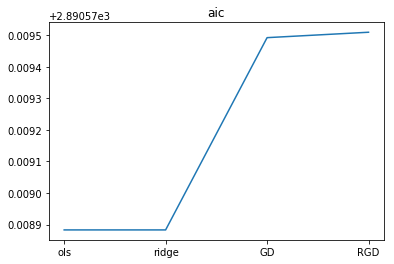

In [31]:
### 1.compared by AIC
algorithms = [ols, ridge, gradient_descent, random_gradient_descent]
names  = ['ols', 'ridge', 'GD', 'RGD']
criterion = [item.aic for item in algorithms]
plt.title('aic')
plt.plot(names , criterion)


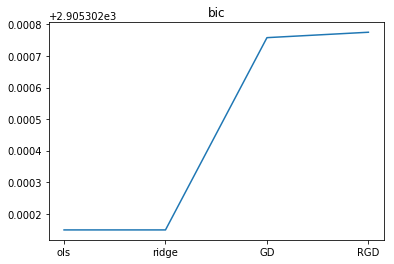

In [32]:
### 2.compared by bic
criterion = [item.bic for item in algorithms]
plt.title('bic')
plt.plot(names , criterion)

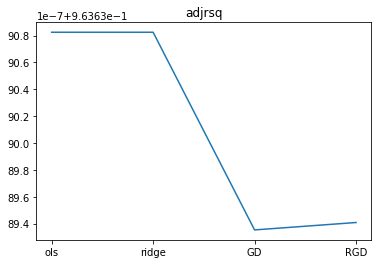

In [33]:
### 3.compared by adjrsq
criterion = [item.adjrsq for item in algorithms]
plt.title('adjrsq')
plt.plot(names , criterion)

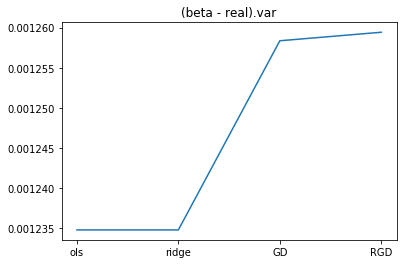

In [34]:
### 4.compared by beta.var
criterion = [(item.beta - b).var() for item in algorithms]
plt.title('(beta - real).var')
plt.plot(names , criterion)